In [1]:
!pip install seaborn

You should consider upgrading via the '/opt/anaconda3/envs/env/bin/python -m pip install --upgrade pip' command.


In [1]:
import requests 
from pprint import pprint as pp
import pandas as pd 
from tqdm import tqdm 
from datetime import date 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import os
import numpy as np

import pymongo
from pymongo import MongoClient
from IPython.display import clear_output 

from utils.misc import subcollection_to_df

%matplotlib inline

[tender Schema](https://gist.github.com/imaginal/bf19e659b34b6acd7ee002f6b88dbf81)

[interesting example, lots, multiple awards ect](https://public.api.openprocurement.org/api/2.5/tenders/98d54c150056474fbedb5420f8aad0d9)

## Download data from API

Depricated: Use scrapy

In [3]:
import datetime


datetime.datetime.fromisoformat('2021-10-01') - datetime.timedelta(days=30)

datetime.datetime(2021, 9, 1, 0, 0)

In [4]:
from urllib.parse import urlparse, parse_qsl, urljoin
import datetime

tz = datetime.timezone(datetime.timedelta(seconds=10800))
start_date = datetime.datetime(2021,1,1,tzinfo=tz)
end_date = datetime.datetime(2021,10,1,tzinfo=tz)

api_path = "https://public.api.openprocurement.org/api/2.5/"

next_page_url = urljoin(api_path,f"tenders?offset={start_date.isoformat()}")
offset_date = start_date

tender_ids = []

while offset_date<end_date:

    clear_output()
    print(f'Date {offset_date} tender ids {len(tender_ids) }')

    page = requests.get(next_page_url).json()
    
    # new next page
    next_page_url = page["next_page"]["uri"]    

    tender_ids += [tender["id"] for tender in page["data"]]

    qs = dict(
        parse_qsl(
            urlparse(next_page_url).query
            )
        )

    # to compare with end date
    offset_date = datetime.datetime.fromisoformat(qs['offset'])

# unique
tender_ids = list(set(tender_ids))

In [ ]:
with open('./scraper/tender_ids.txt', 'w') as f:
    f.writelines(s + '\n' for s in tender_ids)

In [163]:
with open('./scraper/tender_ids.txt', 'r') as f:
    tender_ids = [line.strip() for line in f.readlines()]

len(tender_ids)

476400

In [19]:
client = MongoClient()
db = client['prozorro']
tenders_collection = db['tenders']

# USE SPIDER - work faster and has outothrottle mechanism
def get_tender(tender_id):
    response = requests.get(
        urljoin(api_path+'tenders/', tender_id)
    ).json()

    tender = response["data"]

    del tender['id']
    
    update_info = tenders_collection.update({'_id':tender_id}, tender, upsert=True)
    return update_info

# slow
for tender_id in tqdm(tender_ids):
    
    get_tender(tender_id)


In [172]:
import concurrent.futures

# faster

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     for tender_id, prime in zip(tender_ids, executor.map(get_tender, tender_ids)):
#         clear_output()
#         print('Tender %s is acknowledged: %s' % (tender_id, prime))

## Get data from local Mongo DB

### Read mongo

In [2]:
client = MongoClient()
db = client['prozorro']
collection='tenders'

In [3]:
# https://docs.mongodb.com/manual/tutorial/project-fields-from-query-results/#return-specific-fields-in-embedded-documents

def read_mongo(db, collection, query={}, fields=None, id_to_index=False, limit: int = 0):
    """ Read from Mongo and Store into DataFrame """

    # Make a query to the specific DB and Collection
    
    # filter fields
    _fields = None
    if fields is not None:
        _fields = fields if isinstance(fields, dict) else {field:1 for field in fields}

    cursor = db[collection].find(query, _fields)

    if limit:
        cursor.limit(limit)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor)).rename(columns={'_id':'id'})

    # Delete the _id
    if id_to_index:
        df.set_index('id')

    return df

# You can put filter here or later in pandas dataset
# equvalent to
# SELECT fields
#   FROM collection
#   WHERE query
# df = read_mongo(db, collection='tenders', query={'status':'complete'}, fields=['status', 'items'])


In [8]:
df = read_mongo(db=db, collection=collection, query={}, fields=None, limit=100000)

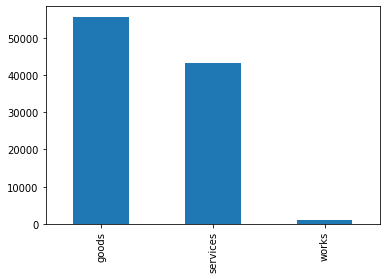

In [15]:
df.mainProcurementCategory.value_counts().plot(kind='bar');

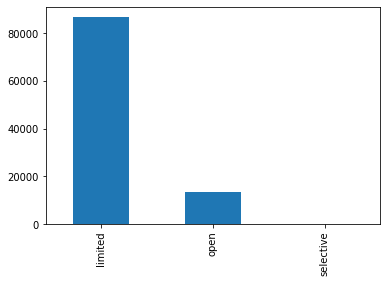

In [16]:
df.procurementMethod.value_counts().plot(kind='bar');

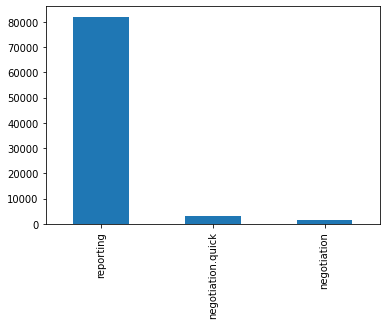

In [21]:
df[df.procurementMethod=='limited'].procurementMethodType.value_counts().plot(kind='bar');

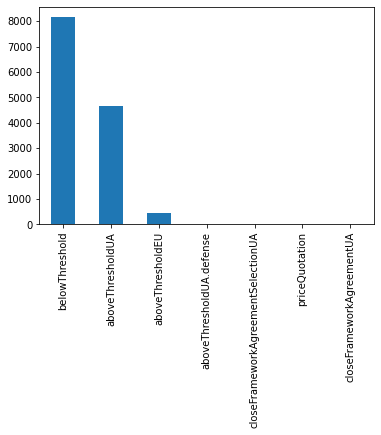

In [23]:
df[df.submissionMethod=='electronicAuction'].procurementMethodType.value_counts().plot(kind='bar');

For most cases all conditions are true for e-auctions:

```
procurementMethod == open 
submissionMethod == electronicAuction
```

So for next steps we will consider `submissionMethod == electronicAuction && status==complete`


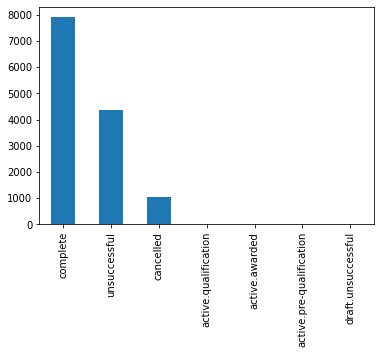

In [24]:
df[df.submissionMethod=='electronicAuction'].status.value_counts().plot(kind='bar');

### Nested collection to separate dataframe example

In [15]:
items_df = subcollection_to_df(df,'items')
items_df.head()

### Create indexies

In [5]:
collection_name='tenders'
collection = db[collection_name]
collection.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]}}

In [7]:
# Do it only ones
collection.create_index('status')

'status_1'

In [14]:
collection.distinct('submissionMethod')

[None, 'electronicAuction']

In [13]:
collection.create_index([('submissionMethod',pymongo.ASCENDING),
                            ('status',pymongo.ASCENDING)],
                            name='status_submissionMethod')

'status_submissionMethod'

### Fix scraped data - str to datetime

In [40]:
from dateutil import parser

def convert_date_mongo(db, collection, fields, query={}, limit: int = 0):

    coll = db[collection]
    cursor = coll.find({})

    if limit:
        cursor.limit(query)

    counter = 0
    for item in cursor:
        counter+= 1
        changed = False
        for field in fields:
            if field in item and isinstance(item[field], str):
                changed = True
                item[field] = parser.parse(item[field])
        
        if changed:
            coll.replace_one({'_id':item['_id']}, item)
        
        if counter%10000==0:
            print(counter)

# convert_date_mongo(db=db, collection=collection, query={'status':'complete', 'submissionMethod': 'electronicAuction'},  fields=['date', 'dateModified'])

## Гіпотеза
Постачальники з історією участі в тендерах, більш ймовірніше будуть подаватися на схожі тендери(географічна близькість, категорія, покупець/тип покупця).

In [25]:
df = read_mongo(db, collection='tenders', query={'submissionMethod': 'electronicAuction'}, fields=['status', 'procuringEntity', 'bids', 'awards', 'items', 'value', 'procurementMethodType', 'mainProcurementCategory', 'procurementMethodType', 'awardCriteria'])
# df.to_csv('electronicAuction.gzip', compression='gzip', index=False)

In [26]:
df.shape

(461212, 10)

## n bids to relative economy 

In [29]:
df.head()

,id,mainProcurementCategory,awardCriteria,status,items,value,bids,procuringEntity,awards,procurementMethodType
0,f48553cf3a7a40978a991e3dbb303f27,goods,lowestCost,active.awarded,"[{'id': '989bb0d67e71415e9336344253073dfa', 'd...","{'amount': 184954.0, 'currency': 'UAH', 'value...","[{'tenderers': [{'name': 'ТОВ ""ХЕППІ ПАРК""', '...",{'name': 'Сектор освіти Кам'янка-Бузької район...,"[{'id': '2a7183c3acf042cdaad4e0781241db50', 's...",belowThreshold
1,276151a943594d3a8bbbce2e22ecad0f,goods,lowestCost,active.awarded,"[{'id': 'b66a6db790ab4d379fbc977863639c6b', 'd...","{'amount': 3811250.0, 'currency': 'UAH', 'valu...","[{'tenderers': [{'name': 'ТОВ НВП ""Гран""', 'id...",{'name': 'Міністерство оборони України (Відділ...,"[{'id': '5d621ed1dff3477fbb1f5e5a088208e7', 's...",aboveThresholdUA
2,8c752192ae7d4be78daeccb249cde0ee,goods,lowestCost,active.awarded,"[{'id': 'a6f2e5a7fe6e4e12b51d9cb384d4a608', 'd...","{'amount': 2500000.0, 'currency': 'UAH', 'valu...","[{'tenderers': [{'name': 'ТОВ ""Торговий Дім Бу...","{'name': 'Червоненська сільська рада', 'identi...","[{'id': 'c51d215385964b589da7efd40483c2df', 't...",aboveThresholdUA
3,65ccf319845043bb9d5fb9163cd74583,goods,lowestCost,active.awarded,"[{'id': 'e48d2c3c26b44e879e76fd818bde7294', 'd...","{'amount': 108907.5, 'currency': 'UAH', 'value...",[{'tenderers': [{'name': 'ТОВАРИСТВО З ОБМЕЖЕН...,{'name': 'МАРКІВСЬКА РАЙОННА ДЕРЖАВНА АДМІНІСТ...,"[{'id': '9b32876733354719b51c5a50f207ae4b', 's...",belowThreshold
4,93a34661ab4d4d6c951e22f0386da655,services,lowestCost,active.awarded,"[{'id': '6975c3750d2ad87bd46f23839746d8e6', 'd...","{'amount': 181915.0, 'currency': 'UAH', 'value...","[{'id': 'a33a2240f05b4fb18009c11989151db7', 's...","{'name': 'ДП ""Петриківський лісгосп""', 'identi...","[{'id': '828928f8a99449998f7d7ca2a2fc9bad', 's...",aboveThresholdUA


In [31]:
df_completed = df[df['status']=='complete']

In [33]:
df_completed['award_amount'] = df_completed.awards.apply(lambda awards: sum([award['value']['amount'] for award in awards]))
df_completed['value_amount'] = df_completed.value.apply(lambda value: value['amount'])
df_completed['economy'] = 100*(df_completed['value_amount'] - df_completed['award_amount'])/df_completed['value_amount']
df_completed['currency'] = df_completed.value.apply(lambda value: value['currency'])
df_completed['numberOfBids'] = df_completed.bids.apply(lambda bids: len(bids)) # numberOfBids
df_completed.shape


(278072, 13)

In [39]:
df_completed[['id','numberOfBids','value_amount','award_amount','economy']].head(20)

,id,numberOfBids,value_amount,award_amount,economy
32097,22cb88ebaac14ab2ac048cec40909ba6,4,1086180.00,591366.00,45.555433
32098,d7ac4dfc5e394932b13f0ba7f50c7f47,5,4125000.00,4000000.00,3.030303
32099,221a19eb687242e29ee270b156167e04,3,2368800.00,2723000.00,-14.952719
32100,621e686f458648558b212c9d50d6b176,2,999600.00,976668.00,2.294118
32101,f07499820f034dcd930138c290bcc54d,2,999600.00,934920.00,6.470588
32102,a207915c730f4235b1995402c1cf39d0,3,892800.00,720000.00,19.354839
32103,90d346e634154be78296a9856ac7f1a3,1,63700.00,44249.45,30.534615
32104,5f66e464c0d94702be1219e1efd20f76,2,90000.00,83000.00,7.777778
32105,a6e01d54b36a47cea22f52d5db0daa41,2,185450.00,343940.00,-85.462389
32106,3efacc853bd64ddba49a6b94e84f442d,1,199998.76,199279.34,0.359712


In [4]:
print(f'Economy below zero {43331/278072}')

Economy below zero 0.15582654851980782%f2


In [42]:
# how is it possible to make bid > than value
sum(df_completed['economy']<0)

43331

In [44]:
# for plot
df_cleaned = df_completed[df_completed['economy']>=0]
df_cleaned = df_cleaned[df_cleaned.currency=="UAH"]

In [46]:
print(len(df_completed[df_completed['numberOfBids']==1])/len(df_completed))
print(len(df_cleaned[df_cleaned['numberOfBids']==1])/len(df_cleaned))

0.3891114531488248
0.458604833520134


In [47]:
df_cleaned['economy_value'] = df_cleaned['value_amount'] - df_cleaned['award_amount']
df_cleaned['economy_theoretical_value'] = df_cleaned['value_amount']*0.35

In [48]:
sum(df_cleaned['economy_theoretical_value']-df_cleaned['economy_value'])

137771780103.40866

137 мільярдів Карл! перевірити викиди!!!

In [49]:
df_grouped = df_cleaned.groupby(by='numberOfBids').agg({'economy':'mean', 'id':'count'}).reset_index()
df_grouped.head(10)

,numberOfBids,economy,id
0,1,4.802026,107613
1,2,11.083768,74587
2,3,21.045868,26716
3,4,25.988572,12200
4,5,29.760735,6022
5,6,31.658671,3111
6,7,34.109298,1683
7,8,33.424821,1044
8,9,35.933713,583
9,10,37.970420,337


In [50]:
# outliers
df_grouped = df_grouped[df_grouped.id>10]

In [51]:
df_grouped['count_log'] = np.log2(df_grouped.id).astype(int)*15

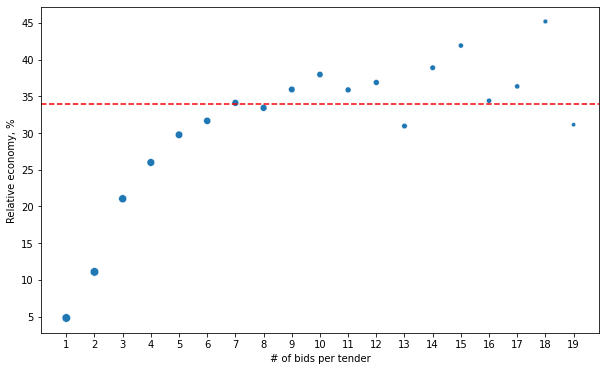

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(34, ls='--', color='red')
ax = sns.scatterplot(ax=ax, data=df_grouped, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(df_grouped.numberOfBids.to_list());

# Relation between the received offers of bidders and the underbid Ukraine

In [53]:
df_grouped.economy.mean()

31.441456744006114

In [55]:
del df_cleaned
del df_grouped

## geocoding

In [56]:
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
# df = read_mongo(db, collection='tenders', query={'submissionMethod': 'electronicAuction'}, fields=['status', 'procuringEntity', 'bids', 'awards', 'items', 'value', 'procurementMethodType', 'mainProcurementCategory', 'procurementMethodType', 'awardCriteria'])

*Частково вирішує проблему*
**Dozorro Проблема 6 Некоректні регіони + місто**
* Визначити всіх учасників і замовників з некоректно визначиними регіонами/містами
* Запропоонувати алгоритм виправлення/уніфікації



* Поле `locality` містить найбільш неструктуровану інформацію, може містиити район, громаду, населений пункт в довільному порядку
* Часто можна зустріти помилки, русизми, неактуальні назви населених пунктів
* Для уніфікації використано відкритий безплатний сервіс Nominatim(визначення геокоду та структурованої інформації про населений пункт, приклад нижче). 
* Обмження Nominatim один запит в секунду - реалізовано кеш, після того як кеш "прогрівся" дані опрацювуються швидко. 
* Для продакшн використання може буде розгорнутий локально, Open-Source GPLv2
* Полу `region` містить дані про область проблеми лише з м. Київ, реалізовно заплатку.
* Реалізолвану функцію, яка вхід приймає структуру адреса на вихід віддає структуровану інфо про геолокіцію
* Інформація про вулиці не використовується.
* Точність 99,5% решту 0,5% можна визначити за поштовим кодом(*лише для покупців procurement entities*)

for entities and suppliers structure remain the same

In [58]:
address = df.procuringEntity.iloc[12345]['address']
address

{'streetAddress': 'вул. Центральна, 53',
 'locality': 'с. Семидуби',
 'region': 'Рівненська область',
 'postalCode': '35650',
 'countryName': 'Україна'}

In [59]:
# resulting query after fixes
query_string = ' '.join([
    locality_fixer(address['locality']), 
    region_fixer(address['region']), 
    countryName_fixer(address['countryName'])
])

query_string

'семидуби рівненська область україна'

In [60]:
# geocoding
from geopy.geocoders import Nominatim

geocoder = Nominatim(user_agent="transparent_chelicks")
gc = geocoder.geocode(query_string)

gc.address, gc.point

('Семидуби, Семидубська сільська громада, Дубенський район, Рівненська область, 35650, Україна',
 Point(50.339008, 25.81513, 0.0))

In [61]:
gc.raw

{'place_id': 1381627,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 337524134,
 'boundingbox': ['50.319008', '50.359008', '25.79513', '25.83513'],
 'lat': '50.339008',
 'lon': '25.81513',
 'display_name': 'Семидуби, Семидубська сільська громада, Дубенський район, Рівненська область, 35650, Україна',
 'class': 'place',
 'type': 'village',
 'importance': 0.39904226699327416,
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_place_village.p.20.png'}

prozorro address to query string

In [62]:
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}

In [66]:
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', verbose=False)

not_located = []
located = []

for row in df.itertuples():

    address = row.procuringEntity['address']

    located.append(address_to_location(address=address, geolocator=geolocator, fixers=fixers))


geolocator.close()
    

In [70]:
loc_err = len([lctd for lctd in located if lctd is None])
print(f'Errors {loc_err}')
print(f'located {len(located)}')
print(f'Not found in {100*loc_err/len(located)} %')

Errors 222
located 461212
Not found in 0.048134046815781026 %


Putting everything together:
*  get entities and geocode them
*  get bidders and geocode them
*  merge datasets
*  calculate some stat

In [69]:
bids_df = subcollection_to_df(df, 'bids')
bids_df.head()

,tenderers,date,id,value,participationUrl,status,selfQualified,selfEligible,documents,parent_id,tender_id,subcontractingDetails,requirementResponses,lotValues,financialDocuments,eligibilityDocuments,parameters
0,"[{'name': 'ТОВ ""СЕРВІС ГРУПП ЛТД""', 'identifie...",2020-12-21T14:11:56.255620+02:00,cdc38f0fad3246bd95124bd2e402bb8a,"{'amount': 591366.3, 'currency': 'UAH', 'value...",https://auction.openprocurement.org/tenders/22...,active,True,True,"[{'id': '1fa8e347afa84941b2bd5cdf5d4be415', 'h...",22cb88ebaac14ab2ac048cec40909ba6,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,NaN,NaN,NaN,NaN
1,[{'name': 'Товариство з обмеженою відповідальн...,2020-12-21T13:48:51.469094+02:00,ee1c8cb11c5949b8a964d7215c60ea8c,"{'amount': 724122.0, 'currency': 'UAH', 'value...",https://auction.openprocurement.org/tenders/22...,active,True,True,"[{'id': 'd0b94be557fc481aa7f503f0cf4ba922', 'h...",22cb88ebaac14ab2ac048cec40909ba6,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'name': 'ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬН...,2020-12-18T17:38:22.576729+02:00,a2fe67c6bd92436aadb6ee253acb866e,"{'amount': 677054.07, 'currency': 'UAH', 'valu...",https://auction.openprocurement.org/tenders/22...,active,True,True,"[{'id': '01465f329b034ce3a1b1861cd222e7e3', 'h...",22cb88ebaac14ab2ac048cec40909ba6,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,NaN,NaN,NaN,NaN
3,[{'name': 'ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬН...,2020-12-21T14:14:10.588327+02:00,1cb08df8ce48438c803e4640a7c6b3a1,"{'amount': 591366.0, 'currency': 'UAH', 'value...",https://auction.openprocurement.org/tenders/22...,active,True,True,"[{'id': 'ae72ae3ea4c541f09b3e12bb208e81a9', 'h...",22cb88ebaac14ab2ac048cec40909ba6,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3559825a07044446bc5c59405dbfcfec,NaN,NaN,deleted,NaN,NaN,NaN,d7ac4dfc5e394932b13f0ba7f50c7f47,d7ac4dfc5e394932b13f0ba7f50c7f47,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# tenderers are subcollection of bids !!! deduplicate after geocodins
tenderers_df = subcollection_to_df(bids_df, 'tenderers')
tenderers_df.head()

,name,identifier,address,contactPoint,scale,parent_id,tender_id,name_en,name_ru
0,"ТОВ ""СЕРВІС ГРУПП ЛТД""","{'scheme': 'UA-EDR', 'id': '38772399', 'legalN...","{'streetAddress': '61202, м. Харків, вул. Ціли...","{'name': 'Рождественська Наталія Михайлівна', ...",sme,cdc38f0fad3246bd95124bd2e402bb8a,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN
1,"Товариство з обмеженою відповідальністю ""Дніпр...","{'scheme': 'UA-EDR', 'id': '39572642', 'legalN...",{'streetAddress': 'вул.Поля будинок 2 літ. А-...,"{'name': 'Ольховікова Аліна', 'name_en': 'Alin...",mid,ee1c8cb11c5949b8a964d7215c60ea8c,22cb88ebaac14ab2ac048cec40909ba6,"LIMITED LIABILITY COMPANY ""DNIPROPETROVSKGAZ Z...",NaN
2,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ «АЛЬЯН...,"{'scheme': 'UA-EDR', 'id': '43726412', 'legalN...","{'streetAddress': 'ВУЛИЦЯ ТОРГОВА, будинок 2',...","{'name': 'Меджер Олексій', 'name_en': 'Medjer ...",mid,a2fe67c6bd92436aadb6ee253acb866e,22cb88ebaac14ab2ac048cec40909ba6,TOVARISTVO Z OBMEZHENOYU VIDPOVIDALNISTYU «ALY...,NaN
3,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ГАЗ.УА""","{'scheme': 'UA-EDR', 'id': '42468262', 'legalN...","{'streetAddress': '04080, м.Київ, ВУЛИЦЯ ОЛЕКС...","{'name': 'ТОВ ГАЗ.УА', 'email': 'GAS.UA.TRADE@...",sme,1cb08df8ce48438c803e4640a7c6b3a1,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN
4,ФОП Михайленко Василь Григорович,"{'scheme': 'UA-EDR', 'id': '2484500939', 'lega...","{'streetAddress': 'пр Героїв, буд. 12 кв. 653'...","{'name': 'Михайленко Василий', 'name_en': 'Mik...",micro,7d57949ae2184cfab7394531f575748f,d7ac4dfc5e394932b13f0ba7f50c7f47,FOP Mihailenko Vasil Grigorovich,NaN


In [82]:
# deduplication if multiple bids from the same tenderer - take last one
tenderers_df['edr'] = tenderers_df.identifier.apply(lambda x:x['id'])
tenderers_df = tenderers_df.drop_duplicates(subset=['edr','tender_id'],keep='last')

In [109]:


from functools import partial
fixers = {
    'locality': locality_fixer,
    'region': region_fixer,
    'countryName': countryName_fixer
}
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', verbose=False)

get_location = partial(address_to_location, geolocator=geolocator, fixers=fixers)
df['procuring_entity_point'] = df.procuringEntity.apply(lambda pe:get_location(pe['address']))
tenderers_df['tenderer_point'] = tenderers_df.address.apply(lambda addr:get_location(addr))


geolocator.close()

In [96]:
tenderers_df.address.iloc[0]

{'streetAddress': '61202, м. Харків, вул. Цілиноградська,58А',
 'countryName': 'Україна'}

In [103]:
# almost 11% that is bas NEEDs further investigation 
# locality and region are set to address field 
100*sum(tenderers_df['tenderer_point'].isna())/len(tenderers_df)

11.198738170347003

In [133]:
tenderers_df

,name,identifier,address,contactPoint,scale,parent_id,tender_id,name_en,name_ru,edr,procuring_entity_point,tenderer_point
0,"ТОВ ""СЕРВІС ГРУПП ЛТД""","{'scheme': 'UA-EDR', 'id': '38772399', 'legalN...","{'streetAddress': '61202, м. Харків, вул. Ціли...","{'name': 'Рождественська Наталія Михайлівна', ...",sme,cdc38f0fad3246bd95124bd2e402bb8a,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,38772399,None,None
1,"Товариство з обмеженою відповідальністю ""Дніпр...","{'scheme': 'UA-EDR', 'id': '39572642', 'legalN...",{'streetAddress': 'вул.Поля будинок 2 літ. А-...,"{'name': 'Ольховікова Аліна', 'name_en': 'Alin...",mid,ee1c8cb11c5949b8a964d7215c60ea8c,22cb88ebaac14ab2ac048cec40909ba6,"LIMITED LIABILITY COMPANY ""DNIPROPETROVSKGAZ Z...",NaN,39572642,"(48.46596125, 34.95939956204188)","(48.46596125, 34.95939956204188)"
2,ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ «АЛЬЯН...,"{'scheme': 'UA-EDR', 'id': '43726412', 'legalN...","{'streetAddress': 'ВУЛИЦЯ ТОРГОВА, будинок 2',...","{'name': 'Меджер Олексій', 'name_en': 'Medjer ...",mid,a2fe67c6bd92436aadb6ee253acb866e,22cb88ebaac14ab2ac048cec40909ba6,TOVARISTVO Z OBMEZHENOYU VIDPOVIDALNISTYU «ALY...,NaN,43726412,"(47.0957648, 37.5499621)","(47.0957648, 37.5499621)"
3,"ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ""ГАЗ.УА""","{'scheme': 'UA-EDR', 'id': '42468262', 'legalN...","{'streetAddress': '04080, м.Київ, ВУЛИЦЯ ОЛЕКС...","{'name': 'ТОВ ГАЗ.УА', 'email': 'GAS.UA.TRADE@...",sme,1cb08df8ce48438c803e4640a7c6b3a1,22cb88ebaac14ab2ac048cec40909ba6,NaN,NaN,42468262,None,None
4,ФОП Михайленко Василь Григорович,"{'scheme': 'UA-EDR', 'id': '2484500939', 'lega...","{'streetAddress': 'пр Героїв, буд. 12 кв. 653'...","{'name': 'Михайленко Василий', 'name_en': 'Mik...",micro,7d57949ae2184cfab7394531f575748f,d7ac4dfc5e394932b13f0ba7f50c7f47,FOP Mihailenko Vasil Grigorovich,NaN,2484500939,"(48.46596125, 34.95939956204188)","(48.46596125, 34.95939956204188)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1916,"ФОП ""КИРКО РУСЛАН ПАВЛОВИЧ""","{'scheme': 'UA-EDR', 'id': '2798720812', 'lega...","{'streetAddress': 'ВУЛИЦЯ РОБОЧА, будинок 152,...","{'name': 'Руслан Кирко', 'email': 'bioplaneta2...",mid,f8d1fdef14d54457b9dd4a254a614065,bd203138a7874940a16fd1eb406ff744,NaN,NaN,2798720812,"(48.46596125, 34.95939956204188)","(48.46596125, 34.95939956204188)"
1917,ФОП БОГАЧУК ОЛЕКСАНДР ГРИГОРОВИЧ,"{'scheme': 'UA-EDR', 'id': '2529415734', 'lega...","{'streetAddress': 'вул.Бакалова,56', 'locality...","{'name': 'Богачук Олександр Григорович', 'name...",sme,5ad7ecfa85bf4193a1e1849629253eb8,5594591560064bdc8b77bf3ce8d85e3c,NaN,NaN,2529415734,"(48.8120874, 29.3893874)","(48.8120874, 29.3893874)"
1918,"ФОП ""ГУСЄВ АНАТОЛІЙ ОЛЕКСАНДРОВИЧ""","{'scheme': 'UA-EDR', 'id': '2708509339', 'lega...","{'streetAddress': 'ВУЛИЦЯ ЯРОСЛАВА МУДРОГО , б...","{'name': 'Анатолій Олександрович Гусєв', 'emai...",mid,9cf44055bd304263ae84cd8e12f04e69,d8696825dace4f6cb641717973edcfbe,NaN,NaN,2708509339,"(47.4033486, 32.4388921)","(47.4033486, 32.4388921)"
1919,ТОВ Алан,"{'scheme': 'UA-EDR', 'id': '24447183', 'legalN...","{'streetAddress': 'вул. Стартова, 26', 'locali...","{'name': 'Бура Катерина Вікторівна', 'name_en'...",mid,de3dcfcab9b04a7cad465638bd808bc1,d8696825dace4f6cb641717973edcfbe,NaN,NaN,24447183,"(48.46596125, 34.95939956204188)","(48.46596125, 34.95939956204188)"


In [135]:
# merged dataframe
pe_tenderer_df = df[~df['procuring_entity_point'].isna()][['id','procuring_entity_point']].merge(
    right=tenderers_df[~tenderers_df['tenderer_point'].isna()][['tender_id','tenderer_point', 'scale']],
    left_on='id',
    right_on= 'tender_id',
    how='inner'
)

In [136]:
pe_tenderer_df

,id,procuring_entity_point,tender_id,tenderer_point,scale
0,22cb88ebaac14ab2ac048cec40909ba6,"(48.3747353, 34.4569858)",22cb88ebaac14ab2ac048cec40909ba6,"(48.46596125, 34.95939956204188)",mid
1,22cb88ebaac14ab2ac048cec40909ba6,"(48.3747353, 34.4569858)",22cb88ebaac14ab2ac048cec40909ba6,"(47.0957648, 37.5499621)",mid
2,d7ac4dfc5e394932b13f0ba7f50c7f47,"(48.46596125, 34.95939956204188)",d7ac4dfc5e394932b13f0ba7f50c7f47,"(48.46596125, 34.95939956204188)",micro
3,d7ac4dfc5e394932b13f0ba7f50c7f47,"(48.46596125, 34.95939956204188)",d7ac4dfc5e394932b13f0ba7f50c7f47,"(48.46596125, 34.95939956204188)",micro
4,221a19eb687242e29ee270b156167e04,"(50.3115386, 34.8868923)",221a19eb687242e29ee270b156167e04,"(49.9923181, 36.2310146)",sme
...,...,...,...,...,...
1684,bd203138a7874940a16fd1eb406ff744,"(48.46596125, 34.95939956204188)",bd203138a7874940a16fd1eb406ff744,"(48.46596125, 34.95939956204188)",mid
1685,5594591560064bdc8b77bf3ce8d85e3c,"(48.9654035, 28.8430131)",5594591560064bdc8b77bf3ce8d85e3c,"(48.8120874, 29.3893874)",sme
1686,d8696825dace4f6cb641717973edcfbe,"(46.9758615, 31.9939666)",d8696825dace4f6cb641717973edcfbe,"(47.4033486, 32.4388921)",mid
1687,d8696825dace4f6cb641717973edcfbe,"(46.9758615, 31.9939666)",d8696825dace4f6cb641717973edcfbe,"(48.46596125, 34.95939956204188)",mid


TODO company size and distance. Assumption the smaller supplier, the closer to PE. Is the oppesite True?

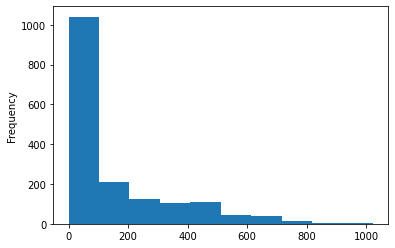

In [137]:
from geopy import distance
pe_tenderer_df['distance']=pe_tenderer_df.apply(lambda x: distance.distance(x.procuring_entity_point, x.tenderer_point).km, axis=1)
pe_tenderer_df['distance'].plot.hist();

Most of the tenderers are registered in range 100 km

In [131]:
sum(pe_tenderer_df['distance']<100), sum(pe_tenderer_df['distance']>=100)

(1032, 657)

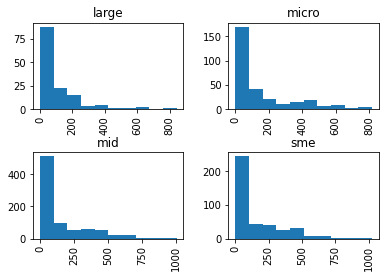

In [142]:
pe_tenderer_df[pe_tenderer_df.scale!='not specified'][['scale','distance']].hist(by='scale');

## DK021 normalization 

In [15]:
# competed eauctions created before 01.03
query_filter = {
    'status':'complete', 
    'submissionMethod': "electronicAuction", 
    # 'date':{'$lt':datetime(2021,3,1)} # BUG dates to tatetime in Mongo
}

df = read_mongo(db, collection='tenders', query=query_filter, fields=['status', 'awards', 'bids', 'items'])

In [22]:
from utils.dk021 import DK021

classifier = DK021.load('./data/dk021.csv')

df = read_mongo(db, collection='tenders', query={'status':'complete'}, fields=['status', 'awards', 'bids'], limit=10000)

items_df['classification_scheme'] = items_df.classification.apply(lambda x: x['scheme'])
items_df['classification_code'] = items_df.classification.apply(lambda x: x.get('id',None))
items_df['classification_description'] = items_df.classification.apply(lambda x: x.get('description',None))
items_df['code_l1'] = items_df.classification_code.apply(lambda code: classifier.get_level_category(code=code, level=1).description)

In [23]:
items_df['code_l1'].value_counts().head(10)

Продукти харчування, напої, тютюн та супутня продукція                                                                                        2203
Медичне обладнання, фармацевтична продукція та засоби особистої гігієни                                                                       2100
Нафтопродукти, паливо, електроенергія та інші джерела енергії                                                                                 1685
Конструкції та конструкційні матеріали; допоміжна будівельна продукція (крім електроапаратури)                                                1066
Комунальні послуги                                                                                                                             851
Послуги з ремонту і технічного обслуговування                                                                                                  846
Сільськогосподарська, фермерська продукція, продукція рибальства, лісівництва та супутня продукція                    

## TODOS

- е-аукціони з потрібними полями за вась час існування Прозоро
- аналіз невдалих аукціонів, припущення - мало учасників, більш географічно віддалено, непопулярні категорії(для постачальника покупця)
- кластеризувати постачальників(активність, тип підприємств з якими взаємодіють, розподіл між покупцями, діапазон сум тендерів)
- Кластеризувати тендери, спробувати знайти залежності між двома типами клістерів
- Для "нового тендеру" будувати граф з послідовностіями подібні постачальники - подібні тендери певної глибини. Зібрані таким чином постачальники порівняти з постачальниками які подалися.